# LSTM Sample Implementation

In [1]:
import glob
from models import DataReader
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()


print('Tensorflow Version: {}'.format(tf.__version__))

Tensorflow Version: 1.5.0-rc1


## Data load

In [13]:
BATCH_SIZE = 100

DIR = '/home/miles/PycharmProjects/MultivariateTimeSeries/data/'
dr = DataReader(
    directory=DIR,
    coin=None,
    batch_size=100,
    train_size=0.9)

#training_batches = dr.get_batch(is_training=True)
#testing_batches = dr.get_batch(is_training=False)
training_batches = dr.read_file_in_batch_size('train')
testing_batches = dr.read_file_in_batch_size('test')

# Network Implementation

## Constants

In [14]:
TIME_STEPS = 28
N_INPUT = 5
N_HIDDEN = 128
LEARNING_RATE = 0.001
NUM_UNITS = 28

tf.reset_default_graph()

In [15]:
# Input placeholders
x = tf.placeholder(tf.float32, [None, TIME_STEPS, N_INPUT])
y = tf.placeholder(tf.float32, [None, 1])

In [16]:
out_weights = tf.Variable(tf.random_normal([NUM_UNITS, 1]))
out_bias = tf.Variable(tf.random_normal([1]))

In [17]:
# Reshape the input tensor from [batch_size, timesteps, n_input] to
# "timesteps" of [batch_size, n_input]
unstacked_inputs = tf.unstack(x, TIME_STEPS, 1)

In [18]:
lstm_layer = tf.contrib.rnn.BasicLSTMCell(NUM_UNITS, forget_bias=1)
outputs, _ = tf.contrib.rnn.static_rnn(lstm_layer, unstacked_inputs, dtype=tf.float32) 

In [19]:
predictions = tf.matmul(outputs[-1], out_weights) + out_bias

In [20]:
loss = tf.losses.mean_squared_error(y, predictions)
train_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

In [21]:
TOTAL_STEPS = 1001
total_training_samples = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_batch = next(testing_batches)

    for step in range(TOTAL_STEPS):
        train_batch = next(training_batches)
        features = next(training_batches).get('features')
        targets = next(training_batches).get('targets')
        feed_dict = {x: features, y: targets}
        
        sess.run(train_step, feed_dict=feed_dict)
        
        if step % 1000 == 0:
            mse = sess.run(loss, feed_dict=feed_dict)
            print(f'Step={step}, Training Loss={mse}')
            
        total_training_samples += BATCH_SIZE
        print(step / TOTAL_STEPS * 100, end='\r')
            
    features = next(testing_batches).get('features')
    targets = next(testing_batches).get('targets')
    feed_dict = {x: features, y: targets}
    p = sess.run(predictions, feed_dict=feed_dict)

            

Step=0, Training Loss=0.07801327109336853
Step=1000, Training Loss=nan


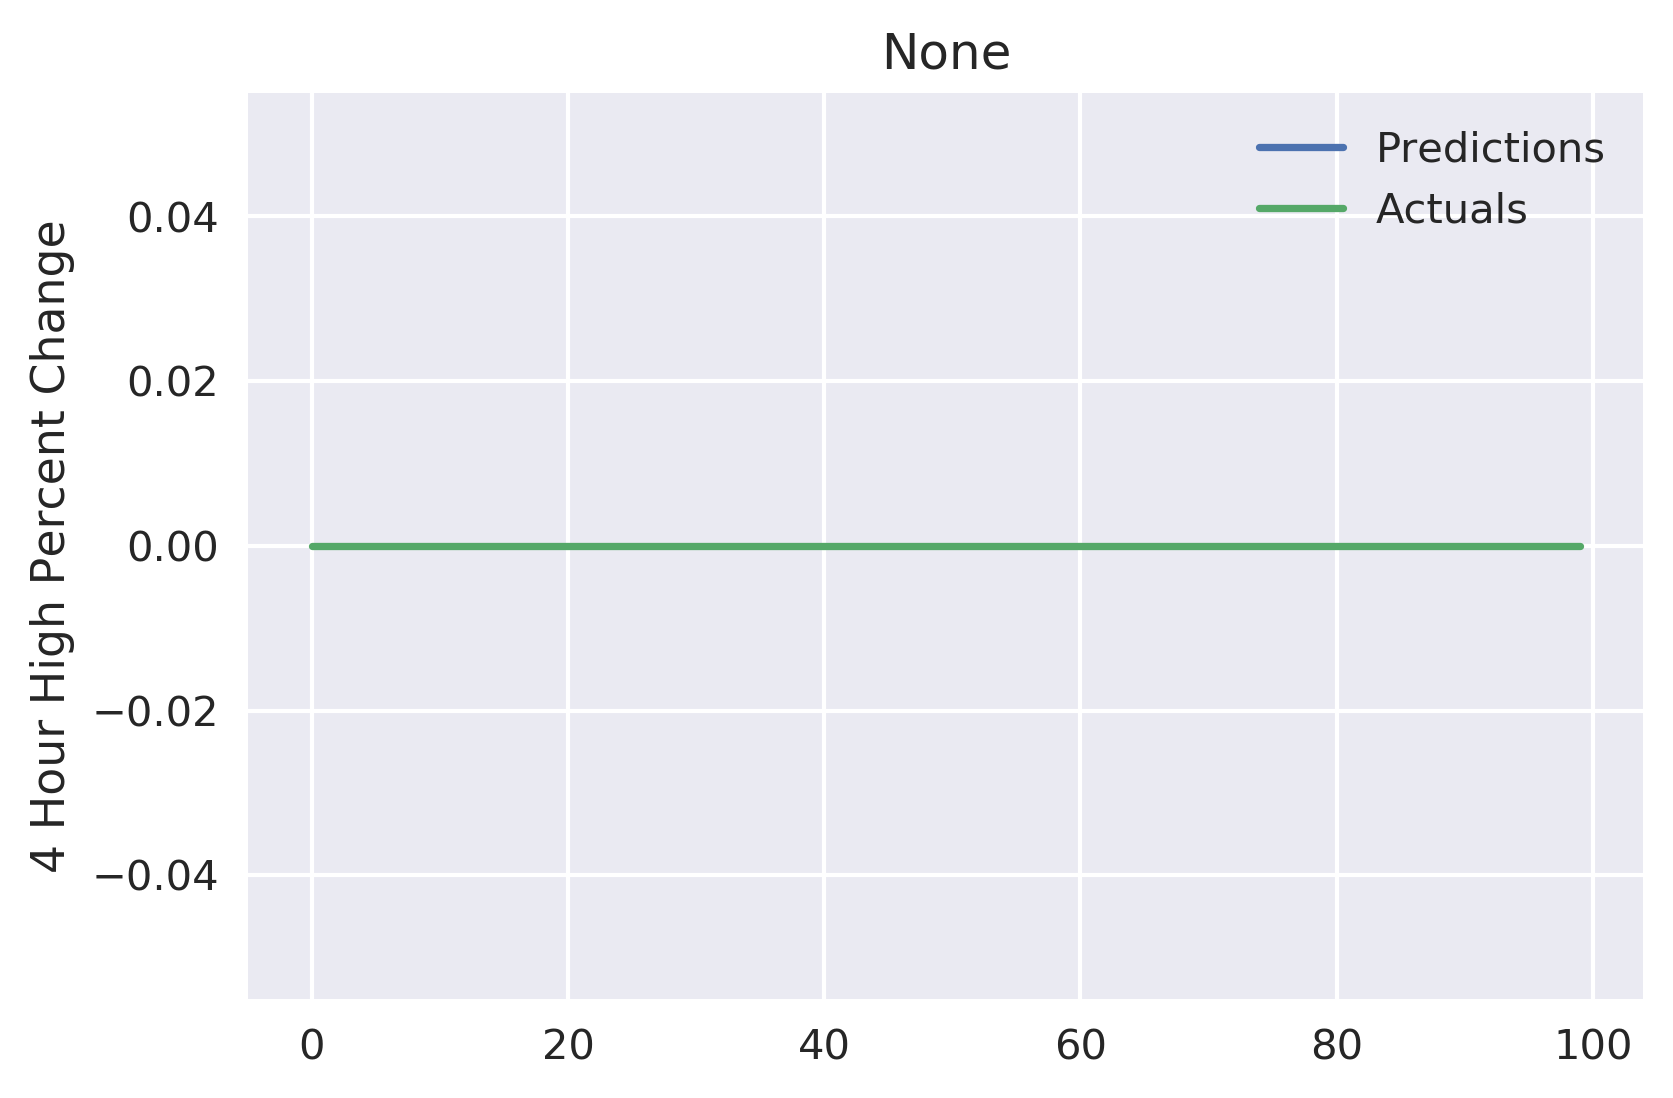

In [22]:
fig, ax = plt.subplots()
fig.set_dpi(300)
ax.plot(p.flatten(), label='Predictions')
ax.plot(targets.flatten(), label='Actuals')
ax.legend()
ax.set_title(dr.coin)
ax.set_ylabel('4 Hour High Percent Change')
plt.show()

fig.savefig('/tmp/dgb_btc_high_predictions.png')

In [ ]:
residuals = (p.flatten() - targets.flatten())

fig, ax = plt.subplots()
sns.distplot((p.flatten() - targets.flatten())* 100, ax=ax)

plt.show()


In [ ]:
np.std(residuals* 100)

In [ ]:
np.mean(residuals*100)

In [ ]:
sns.regplot(targets.flatten(), p.flatten())